In [4]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import Formatting
from scipy import stats
import Metrics
from Constants import Const
import copy
import Utils
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import power_divergence, chisquare, chi2_contingency

from dtaidistance import dtw_ndim, clustering
from Models import PatientKNN
import Cluster
pd.set_option('display.max_columns', None)

In [5]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
#Andrews code for formatting the symptom data

In [28]:
def get_dates(columns):
    alldates = set([])
    for col in columns:
        if 'mdasi' in col:
            week = symptom_weektime(str(col))
            alldates.add(week)
    return sorted(alldates)

def valid_cols(df, columns):
    valid = list(set(df.columns).intersection(set(columns)))
    invalid = set(columns) - set(df.columns)
    return valid,invalid
    

def get_mdasi_rename_dict():
    #placehold for renaming columns later, based on "MDASI.csv" headings
    col_dict = {'site_of_tumor': 'subsite',
                'RT_duration': 'duration',
                'AGE': 'age',
                't_nominal': 't_stage',
                'n_nominal': 'n_stage',
                'Overall_survival': 'os',
                'Death_days': 'death_days',
                'Fudays': 'followup_days',
                'bc':'bootcamp_therapy',
                'Performance_score': 'performance_score',
                'm':'m_stage'
               }
    return col_dict

def format_mdasi_columns(df):
    cd = get_mdasi_rename_dict()
    df = df.rename(columns = cd, inplace=False)
    df.loc[:,'is_male'] = df.sex.apply(lambda x: x > 1)
    df.loc[:,'is_ajcc_8th_edition'] = df.ajcc_version.apply(lambda x : (x > 1 if not np.isnan(x) else -1))
    df.loc[:,'hpv'] = df.p16_hpv_postive.apply(lambda x: (x if x in [0,1] else -1))
    df.loc[~df['os'].isnull(),'os'] = df.loc[~df['os'].isnull(),'os'].apply(lambda x: int('alive' in str(x.lower())))
    return df

def load_mdasi(file = None):
    if file is None:
        file = Const.mdasi_folder + 'MDASI.csv'
    dframe = pd.read_csv(file)
    return format_mdasi_columns(dframe)

def fix_bmi_stuff(df):
    #add bmi info
    df = df.copy()
    to_impute = ['baseline_height','baseline_weight','end_of_treatment_weight','wk6_weight']
    to_impute = [c for c in to_impute if c in df.columns]
    for col in to_impute:
        df[col] = df[col].apply(lambda x: pd.to_numeric(x,errors='coerce')).astype(float)
#     df[to_impute] = df[to_impute].fillna(df[to_impute].median())
    #we have a people who weight 600+kg apparently so i'm asusming there's and extra 0
    for col in [c for c in to_impute if 'weight' in c]:
        df[col] = df[col].apply(lambda x: x/10 if x > 500 else x)
        
    df['baseline_height'] = df['baseline_height'].apply(lambda x: x*10 if x < 50 else x)
    #I think one person has 80 cm instead of 180 cm idk
    df.loc[df[df.id.astype(int) == 576].index,['baseline_height']] = 180
    return df.copy()

def fix_dose_values(dframe):
    new_df = dframe.copy()
    
    def fix_dose_frac(df):
        temp = df.copy()
        for i,row in temp.iterrows():
            if np.nan_to_num(row['rt_fraction']) > np.nan_to_num(row['rt_dose']):
                tdose = row['rt_dose']
                tfrac = row['rt_fraction']
                temp.loc[i,'rt_dose'] = tfrac
                temp.loc[i,'rt_fraction'] = tdose
        return temp
    
    def format_dose(x):
        if np.isnan(x):
            return 0
        while x > 100:
            x = x/10
        return np.rint(x)
    
    new_df = fix_dose_frac(new_df)
    new_df['rt_dose'] = new_df['rt_dose'].apply(format_dose)
    return new_df.copy()

def add_surgery(df,loc = 3):
    new_df = df.copy()
    surgery = new_df['id'].apply(lambda x: int(int(x) in Const.mdasi_surgery))
    surgery_alone = new_df['id'].apply(lambda x: int(int(x) in Const.mdasi_surgery_alone))
    new_df.insert(loc, 'surgery_before_rt', surgery)
    new_df.insert(loc+1, 'surgery_alone',surgery_alone)
    return new_df.copy()

def load_mdasi_xlsx(file = None,format_cols=True):
    if file is None:
        file = Const.mdasi_folder + 'MDASI_09092021.xlsx'
    dframe = pd.read_excel(file)
    dframe = dframe.drop([c for c in dframe.columns if 'Unnamed: ' in c],axis=1)
    dframe = fix_bmi_stuff(dframe)
    dframe = fix_dose_values(dframe)
    dframe  =add_surgery(dframe)
    if format_cols:
        dframe = format_mdasi_columns(dframe)
    return dframe

# df = load_mdasi()
df = load_mdasi_xlsx(format_cols=False)
df.to_csv(Const.mdasi_folder + 'MDASI_0909201_surgery_updated.csv',index=False)

In [5]:
def symptom_weektime(string):
    #parses the column for each symptom into the number of weeks after baseline
    s = string.lower().strip().replace('_','')
    if 'baseline' in s:
        return 0
    elif 'startrt' in s:
        return 1
    elif 'endrt' in s:
        return 7
    week_regex = re.match("wk(\d+)",s)
    postweek_regex = re.match('wk(\d+)post',s)
    month_regex = re.match('m(\d+)',s)
    if postweek_regex is not None:
        return 7 + int(postweek_regex.group(1))
    elif week_regex is not None:
        return int(week_regex.group(1))
    elif month_regex is not None:
        return 7 + int(4.35*float(month_regex.group(1)))
    return -1

def get_symptom(string):
    s = string.lower().strip()
    regex = re.match('.*mdasi_([a-z]+)',s)
    if regex is not None:
        return regex.group(1)
    #because someone decided changing the name scheme for activity was a good idea
    else:
        if 'activity' in s:
            return 'activity'
    return False

def symptom_dict(df,
                 to_keep_clinical = None, 
                 to_keep_demographics = None, 
                 to_keep_treatment = None,
                 to_keep_other = None,
                 default_value = np.nan,
                 as_df = False,
                symptoms = None):
    entrys = {}
    if to_keep_clinical is None:
        to_keep_clinical = ['subsite','duration',
                            't_stage','n_stage',
                            'is_ajcc_8th_edition',
                            'hpv','rt','ic',
                            'concurrent','performance_score',
                           'os','followup_days','chemotherapy',
#                             'dysarthria_late','trach','dilation',
#                             'bootcamp_therapy','pna_ever',
                            'typetreatment','treatment2',
                           ]
    if to_keep_demographics is None:
        to_keep_demographics = ['is_male','age']
    if to_keep_treatment is None:
        to_keep_treatment = ['rt','ic','concurrent','nd','rt_type']
    if to_keep_other is None:
        to_keep_other = ['id','followup_days','performance_score','status_at_enrollememt']
    all_cols = [to_keep_clinical,to_keep_demographics,to_keep_treatment,to_keep_other]
    for i,c in enumerate(all_cols):
        valid,invalid = valid_cols(df,c)
        if len(invalid) > 0:
            print('missing columns',invalid)
            all_cols[i] = valid
    if symptoms is None:
        symptoms = Const.symptoms
    dates = get_dates(df.columns)
    for i, row in df.iterrows():
#         for name, cols in zip(['clinical','demographics','treatment','other'],all_cols):
#             pentry[name] = row[cols].to_dict()
        pentry = {}
        for cols in all_cols:
            for k,v in row[cols].to_dict().items():
                pentry[k] = v
        cols = list(row.index)
        p_symptoms = {}
        all_nan = True
        for col in cols:
            symp = get_symptom(str(col))
            if symp:
                assert(symp in symptoms)
                week = symptom_weektime(str(col))
                entry = p_symptoms.get(symp,{})
                entry[week] = row[col]
                if not np.isnan(row[col]):
                    all_nan = False
                p_symptoms[symp] = entry
        
        missing = set(symptoms) - set(p_symptoms.keys())
        if len(missing) > 0:
            print('missing',missing)
        
        sympts = {s:[p_symptoms[s].get(d,default_value) for d in dates] for s in p_symptoms.keys()}
        if as_df: 
            for k,v in sympts.items():
                pentry['symptom_'+k] = v
        else:
            pentry['symptoms'] = sympts
        if not all_nan:
            entrys[row['id']] = pentry
        else:
            print(row['id'],'missing all symtpom data')
    if as_df:
        ddf = pd.DataFrame(entrys).T
        ddf['dates'] = [dates for i in ddf.index]
        return ddf
    else:
        ddict = {'dates': dates, 'patients': entrys}
        return ddict
ddf = symptom_dict(df,as_df=True)
ddf.head()

,age,chemotherapy,concurrent,duration,followup_days,hpv,ic,id,is_ajcc_8th_edition,is_male,n_stage,nd,os,performance_score,rt,rt_type,status_at_enrollememt,subsite,symptom_activity,symptom_appetite,symptom_choke,symptom_constipation,symptom_distress,symptom_drowsy,symptom_drymouth,symptom_enjoy,symptom_fatigue,symptom_memory,symptom_mood,symptom_mucositis,symptom_mucus,symptom_nausea,symptom_numb,symptom_pain,symptom_relations,symptom_sad,symptom_skin,symptom_sleep,symptom_sob,symptom_swallow,symptom_taste,symptom_teeth,symptom_voice,symptom_vomit,symptom_walking,symptom_work,t_stage,treatment2,typetreatment,dates
1,72,concurrent_chemotherapy,1,44,203,1,0,1,False,True,n2b,0,0,0,1,3,Previously_Untreated,BOT,"[0.0, nan, nan, nan, nan, 1.0, 2.0, 8.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 1.0, 5.0, 2.0, ...","[0.0, nan, nan, nan, nan, 1.0, 1.0, nan, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 1.0, 0.0, ...","[1.0, nan, nan, nan, nan, 1.0, 3.0, 6.0, 7.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, 1.0, nan, 1.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 8.0, 2.0, ...","[0.0, nan, nan, nan, nan, 2.0, 2.0, 4.0, 1.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, nan, 5.0, 7.0, 3.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[1.0, nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 4.0, 8.0, 5.0, ...","[1.0, nan, nan, nan, nan, 0.0, 4.0, 7.0, 8.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 2.0, 3.0, 7.0, 2.0, ...","[0.0, nan, nan, nan, nan, 1.0, 3.0, 4.0, 8.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 2.0, 5.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.0, nan, nan, nan, nan, 0.0, 3.0, 7.0, 4.0, ...","[0.0, nan, nan, nan, nan, 0.0, 0.0, 10.0, 4.0,...",t1,Cr,Cr,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]"
2,47,concurrent_chemotherapy,1,44,1084,-1,0,2,-1,True,n0,0,1,0,1,5,Previously_Untreated,Tonsil,"[nan, nan, nan, nan, nan, nan, nan, 4.0, 4.0, ...","[nan, nan, nan, nan, nan, nan, nan, 6.0, 3.0, ...","[nan, nan, nan, nan, nan, nan, nan, 3.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 4.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 2.0, ...","[nan, nan, nan, nan, nan, nan, nan, 3.0, 2.0, ...","[nan, nan, nan, nan, nan, nan, nan, 4.0, 8.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 3.0, ...","[nan, nan, nan, nan, nan, nan, nan, 4.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 4.0, 4.0, ...","[nan, nan, nan, nan, nan, nan, nan, 7.0, 7.0, ...","[nan, nan, nan, nan, nan, nan, nan, 9.0, 8.0, ...","[nan, nan, nan, nan, nan, nan, nan, 5.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 3.0, 3.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 3.0, ...","[nan, nan, nan, nan, nan, nan, nan, 2.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 5.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 7.0, 4.0, ...","[nan, nan, nan, nan, nan, nan, nan, 7.0, 5.0, ...","[nan, nan, nan, nan, nan, nan, nan, 6.0, 4.0, ...","[nan, nan, nan, nan, nan, nan, nan, 3.0, 1.0, ...","[nan, nan, nan, nan, nan, nan, nan, 3.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 1.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, 4.0, 3.0, ...",t4,Cr,Cr,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]"
3,80,concurrent_chemotherapy,1,43,857,-1,0,3,False,True,n2b,0,1,1,1,2,Previously_Untreated,Soft_palate,"[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[5.0, na

In [6]:
ddf.to_csv(Const.data_dir + 'patient_symptom_formatted.csv')

In [7]:
ddict = symptom_dict(df)
ddict
Utils.np_dict_to_json(ddict,Const.data_dir + "patients_symptom_data.json",True)

True

In [8]:
def key_points(sequence,
               dates,
               breaks,
               sort = False):
    vals = [np.nan for b in breaks]
    for i,group in enumerate(breaks):
        #do it chronologically or hard code priority order
        if sort:
            g = sorted(group, key = lambda x: -x)#sort in reverse
        else:
            g = [i for i in group]
        for week in g:
            pos = dates.index(week)
            val = sequence[pos]
            if not np.isnan(val):
                vals[i] = val
                break
    return vals

def check_all_symptoms(symptom_entry,threshold=1):
    n_missing = 0
    for s,vals in symptom_entry.items():
        if np.isnan(vals).any():
            n_missing += 1
    if n_missing >= threshold:
        return False
    return True

def group_symptom_dates(ddict, date_groups=None,drop_invalid =True,symptoms=None):
    #agglomerates symtpom questions airs based on a hard-coded priorty of dates to 
    if date_groups is None:
        #this the first group is the first inner list, it will try the first entry, then the second, ect
        #drop_invalid = True makes this ignore patients without all the symptoms, otherwise they're included with nans
        date_groups = [[1,0,2],[4,3,2,5],[7,6,5,4],[13,7],[33,59,85,268]]
    new_dict = {'grouped_dates': date_groups, 'patients': {}}
    valid_pids = []
    for pid, entry in ddict['patients'].items():
        new_entry = {}
        for symptom, vals in entry['symptoms'].items():
            if symptoms is not None and symptom not in symptoms:
                continue
            grouped_symptoms = key_points(vals,ddict['dates'],date_groups)
            new_entry[symptom] = grouped_symptoms
        if drop_invalid and not check_all_symptoms(new_entry):
            continue
        new_dict['patients'][pid] = {'grouped_symptoms':new_entry}
        valid_pids.append(pid)
    return new_dict, valid_pids

def get_pstate_dict(ddict,date_groups = None,symptoms = None,fields = None):
    groups, pids = group_symptom_dates(ddict,symptoms)
    nstates = len(groups['grouped_dates'])
    statedict = {}
#     if fields is None:
#         fields = {'clinical': ['subsite','hpv','t_stage'],
#                   'treatment':['ic','rt','concurrent']}
    for pid, sentry in groups['patients'].items():
        pentry = ddict['patients'][pid]
        static_vals = {}
        if fields is not None:
            for k, klist in fields.items():
                for kk in klist:
                    static_vals[kk] = pentry[k][kk]
        new_entry = {}
        for state in range(nstates):
            currstate = copy.copy(static_vals)
            for symptom, svals in sentry['grouped_symptoms'].items():
                currval = svals[state]
                currstate[symptom] = currval
            new_entry['state_'+str(state)] = currstate
        statedict[pid] = new_entry
    return statedict, pids

def as_val(key,val):
    subsite_keys = {
        'NOS':0,
        'BOT': 1,
        'Tonsil': 2,
        'Soft_palate': 3,
        'Pharyngeal_wall': 4
    }
    if 'site' in key:
        return subsite_keys.get(val,0)
    else:
        return float(val)
            

def get_symptom_sim_array(statearray, sim_func = None):
    if sim_func == None:
        sim_func = lambda x,y: 1/(1+dtw_ndim.distance(x,y))
    npatients = statearray.shape[0]
    array = np.zeros((npatients,npatients))
    for p in np.arange(npatients):
        for p2 in np.arange(p+1,npatients):
            array[p,p2] = sim_func(statearray[p],statearray[p2])
            if(np.isnan(array[p,p2])):
                print(array[p,p2],p,p2,'\n',statearray[p],'\n',statearray[p2])
    array += array.transpose()
    np.fill_diagonal(array,sim_func(statearray[0],statearray[0]))
    return array

def predict_symptom_clusters(ddict, clusterer = None, sim_func=None):
    statearray, pids = get_state_array(ddict)
    sim = get_symptom_sim_array(statearray,sim_func=sim_func)
     
    if clusterer is None:
        clusterer = Cluster.SimilarityClusterer(4)
        
    clusters = clusterer.fit_predict(sim)
    knn = PatientKNN(n_match_bounds = [10,20],match_threshold=.07)
    neighbors = knn.get_matches(sim)
    
    scluster_dict = {}
    i=0
    
    for i,pid in enumerate(pids):
        entry = {'cluster': clusters[i]}
        entry['neighbor_ids'] = [pids[ii] for ii in neighbors[i]]
        entry['similarity'] = sim[i]#sim[i,neighbors[i]]
        scluster_dict[pid] = entry
        i += 1
    return scluster_dict

def get_state_array(ddict,date_groups = None,symptoms = None,fields = None,fillna = True):
    statedict, pids = get_pstate_dict(ddict,date_groups,symptoms,fields)
    sorted_ids = sorted(statedict.keys())
    sorted_states = sorted(statedict[sorted_ids[0]].keys())
    sorted_keys = sorted(statedict[sorted_ids[0]][sorted_states[0]].keys())
    state_array = []
    for pid in sorted_ids:
        plist = []
        for state in sorted_states:
            slist = [as_val(k,statedict[pid][state][k]) for k in sorted_keys]
            plist.append(slist)
        state_array.append(plist)
    ##npatients x nstates x dim
    statearray = np.array(state_array)
    nanvals = np.argwhere(np.isnan(statearray))
    if fillna:
        for nanidx in nanvals:
            #replace missing values with the mode, for now
            allstates = [i for i in statearray[:,nanidx[1],nanidx[2]] if ~np.isnan(i)]
            mode = stats.mode(allstates).mode
            assert(len(mode) <= 1)
            statearray[nanidx] = mode[0]
    return statearray, pids

def add_clusters(ddict, clusterer=None,sim_func=None):
    sc = predict_symptom_clusters(ddict,clusterer=clusterer,sim_func=sim_func)
    merged_ddict = {}
    for pid, pentry in sc.items():
        temp = {k:v for k,v in pentry.items()}
        pdata = ddict['patients'].get(pid)
        for k,v in pdata.items():
            if type(v) is dict:
                for kk,vv in v.items():
                    temp[k+'_'+kk] = vv
            else:
                temp[k] = v
        merged_ddict[pid] = temp
    merged_mdasi_df = pd.DataFrame(merged_ddict).T
    return merged_mdasi_df

def contingency(v1,v2):
    n_v1 = len(np.unique(v1))
    n_v2 = len(np.unique(v2))
    table = np.zeros((n_v1,n_v2))
    for i, vv1 in enumerate(np.unique(v1)):
        for ii,vv2 in enumerate(np.unique(v2)):
            in_cell = (v1 == vv1) & (v2 == vv2)
            table[i,ii] = in_cell.sum()
    return table

def mdf_state_array(mdf,fill_na = True):
    s_cols = [c for c in mdf.columns if 'symptoms_' in c]
    array = np.stack(mdf[s_cols].apply(lambda x: np.stack(x).ravel(), axis=1).values)
    if fill_na:
        array = np.nan_to_num(array)
    return array

def get_eval_df(merged_df, ground_truths = None,ddict=None):
    if ground_truths is None:
        ground_truths = ['os','concurrent','t_stage']
    temp_df = merged_df.copy()
    sims = np.stack(temp_df.similarity.values)
    
    eps = .0001
    dists = (1 - sims - eps)/(sims + eps)
    labels = temp_df.cluster
    
    silhouette = silhouette_score(dists,labels)
    res = {'silhouette': silhouette}
    
#     temp_x = mdf_state_array(temp_df,fill_na=True)
#     res['ch_score'] = calinski_harabasz_score(temp_x,labels)
    for gt in ground_truths:
        valid = ~temp_df[gt].isnull()
        gt_df = temp_df[valid]
        
        outcome = gt_df[gt]
        gt_labels = gt_df.cluster.astype('int')
        
        ctable = contingency(gt_labels,outcome)
        res[gt+'_chi2'] = chi2_contingency(ctable)[1]
    return res


def test_clusterers(ddict):
    clusterers = []
#     Cluster.SimilarityClusterer(2,link='single'),
#         Cluster.SimilarityClusterer(3,link='single'),
#         Cluster.SimilarityClusterer(4,link='single'),
#         Cluster.SimilarityClusterer(2,link='average'),
#         Cluster.SimilarityClusterer(3,link='average'),
#         Cluster.SimilarityClusterer(4,link='average'),
#         Cluster.SimilarityClusterer(2,link='weighted'),
#         Cluster.SimilarityClusterer(3,link='weighted'),
#         Cluster.SimilarityClusterer(4,link='weighted'),
#         Cluster.SimilarityClusterer(2,link='centroid'),
#         Cluster.SimilarityClusterer(3,link='centroid'),
#         Cluster.SimilarityClusterer(4,link='centroid'),
#         Cluster.SimilarityClusterer(2), 
#         Cluster.SimilarityClusterer(3), 
#         Cluster.SimilarityClusterer(4), 
    for link in ['ward','average','weighted','single','centroid']:
        for n in [3,4,5]:
            clusterers.append(Cluster.SimilarityClusterer(n,link=link))
    #sym func needs to take a 2d matrix 
    dist2sim = lambda x: 1/(1+x) if x != -1 else 0
    sim_funcs = {
        'dtia': lambda x,y: dist2sim(dtw_ndim.distance(x,y)),
#         'jaccard': lambda x,y: dist2sim(Metrics.jaccard_distance(x.ravel(),y.ravel())),
#         'euclidean': lambda x,y: np.sum(x.ravel()**2 - y.ravel()**2)**.5,
#         'mae': lambda x,y: np.sum(np.abs(x.ravel() - y.ravel())),
#         'dtia_psi1': lambda x,y: dist2sim(dtw_ndim.distance(x,y,psi=1)),
#         'dtia_prune': lambda x,y: dist2sim(dtw_ndim.distance(x,y,use_pruning=True)),
#         'dtia_p.01': lambda x,y: dist2sim(dtw_ndim.distance(x,y,penalty=.01)),
#         'dtia_p1': lambda x,y: dist2sim(dtw_ndim.distance(x,y,penalty=1)),
#         'dtia_w1': lambda x,y: dist2sim(dtw_ndim.distance(x,y,window=1)),
#         'dtia_w2': lambda x,y: dist2sim(dtw_ndim.distance(x,y,window=2)),
#         'dtia_w3': lambda x,y: dist2sim(dtw_ndim.distance(x,y,window=3)),
#         'dtia_s5': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=5)),
#         'dtia_s6': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=6)),
#         'dtia_s7': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=7)),
#         'dtia_s8': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=8)),
#         'dtia_s9': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=9)),
#         'dtia_s5w1': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=5)),
#         'dtia_s6w1': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=6)),
#         'dtia_s7': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=7)),
#         'dtia_s8': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=8)),
#         'dtia_s9': lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=9)),
    }
    for mstep in [None,5,6,7,8]:
        for window in [None,1,2,3,4]:
            for penalty in [0,.01,.1,1]:
                for prune in [True,False]:
                    sfun = lambda x,y: dist2sim(dtw_ndim.distance(x,y,max_step=mstep,window=window,penalty=penalty,use_pruning=prune))
                    sname = 'dtia_' + 'w' + str(window) + '_s' + str(mstep) + '_p' + str(penalty)
                    if prune:
                        sname += '_prune'
                    sim_funcs[sname] = sfun
    res = []
    for clusterer in clusterers:
        for sfunc_name, sim_func in sim_funcs.items():
            try:
                mdf = add_clusters(ddict,clusterer=clusterer,sim_func=sim_func)
                results = get_eval_df(mdf,ddict=ddict)
                results['clusterer'] = clusterer.brief()
                results['sim_func'] = sfunc_name
                print(clusterer.brief(), sfunc_name, results['silhouette'])
                res.append(results)
            except Exception as e:
                print(e)
                break
    return pd.DataFrame(res)
            
# test = test_clusterers(ddict)

KeyboardInterrupt: 

In [ ]:
# test.sort_values('silhouette',ascending=False).T

In [12]:
best_mdf = add_clusters(ddict, clusterer=Cluster.SimilarityClusterer(6), sim_func = lambda x,y: 1/(1+dtw_ndim.distance(x,y,max_step=7)))
best_mdf

,age,chemotherapy,cluster,concurrent,duration,followup_days,hpv,ic,id,is_ajcc_8th_edition,is_male,n_stage,nd,neighbor_ids,os,performance_score,rt,rt_type,similarity,status_at_enrollememt,subsite,symptoms_activity,symptoms_appetite,symptoms_choke,symptoms_constipation,symptoms_distress,symptoms_drowsy,symptoms_drymouth,symptoms_enjoy,symptoms_fatigue,symptoms_memory,symptoms_mood,symptoms_mucositis,symptoms_mucus,symptoms_nausea,symptoms_numb,symptoms_pain,symptoms_relations,symptoms_sad,symptoms_skin,symptoms_sleep,symptoms_sob,symptoms_swallow,symptoms_taste,symptoms_teeth,symptoms_voice,symptoms_vomit,symptoms_walking,symptoms_work,t_stage,treatment2,typetreatment
4,69,concurrent_chemotherapy,3,1,44.9583,1333,1,0,4,-1,False,n2b,0,"[454, 452, 451, 450, 449, 447, 446, 444, 443, ...",1,1,1,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Previously_Untreated,Tonsil,"[nan, 0.0, 0.0, 5.0, 6.0, 7.0, 8.0, 9.0, 3.0, ...","[nan, 4.0, 3.0, 9.0, 9.0, 10.0, 7.0, 10.0, 10....","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 9.0, 7.0, 8.0, 8.0, 6.0, 7.0, 8.0, 5.0, ...","[nan, 2.0, 3.0, 6.0, 9.0, 8.0, 8.0, 9.0, 7.0, ...","[nan, 0.0, 3.0, 8.0, 9.0, 10.0, 8.0, 10.0, 10....","[nan, 0.0, 7.0, 9.0, 9.0, 10.0, 9.0, 10.0, 8.0...","[nan, 3.0, 4.0, 6.0, 9.0, 7.0, 7.0, 10.0, 7.0,...","[nan, 2.0, 0.0, 2.0, 4.0, 3.0, 3.0, 3.0, 2.0, ...","[nan, 0.0, 7.0, 9.0, 8.0, 9.0, 8.0, 9.0, 5.0, ...","[nan, 0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 6.0, 8.0, ...","[nan, 0.0, 3.0, 3.0, 3.0, 4.0, 3.0, 6.0, 7.0, ...","[nan, 2.0, 3.0, 7.0, 7.0, 2.0, 1.0, 2.0, 0.0, ...","[nan, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 0.0, 3.0, 3.0, 3.0, 3.0, 4.0, 7.0, 3.0, ...","[nan, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, ...","[nan, 10.0, 9.0, 9.0, 9.0, 9.0, 10.0, 9.0, 8.0...","[nan, 0.0, 9.0, 8.0, 7.0, 5.0, 9.0, 8.0, 4.0, ...","[nan, 2.0, 3.0, 2.0, 0.0, 0.0, 0.0, 5.0, 7.0, ...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 0.0, 6.0, 9.0, 9.0, 8.0, 9.0, 10.0, 10.0...","[nan, 0.0, 3.0, 9.0, nan, 10.0, 9.0, 10.0, 10....","[nan, 0.0, 4.0, 1.0, 3.0, 9.0, 7.0, 9.0, 0.0, ...","[nan, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, ...","[nan, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[nan, 0.0, 0.0, 1.0, 3.0, 5.0, 3.0, 6.0, 0.0, ...","[nan, 0.0, 0.0, 3.0, 5.0, 4.0, 3.0, 4.0, 0.0, ...",t2,Cr,Cr
7,48,concurrent_chemotherapy,3,1,24.9583,1201,0,0,7,False,True,n2b,0,"[4, 454, 452, 451, 450, 449, 447, 446, 444, 443]",1,1,1,5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Previously_Untreated,NOS,"[0.0, 0.0, 0.0, 3.0, 2.0, nan, 2.0, nan, 1.0, ...","[0.0, 0.0, 0.0, 6.0, 7.0, nan, 4.0, nan, 2.0, ...","[0.0, 0.0, 0.0, 1.0, 5.0, nan, 5.0, nan, 1.0, ...","[nan, 1.0, 1.0, 1.0, 3.0, nan, 3.0, nan, 4.0, ...","[0.0, 4.0, 3.0, 1.0, 2.0, nan, 3.0, nan, 3.0, ...","[1.0, 1.0, 0.0, 2.0, 2.0, nan, 1.0, nan, 1.0, ...","[2.0, 4.0, 5.0, 8.0, 2.0, nan, 3.0, nan, 8.0, ...","[0.0, 0.0, 1.0, 2.0, 1.0, nan, 1.0, nan, 1.0, ...","[1.0, 1.0, 1.0, 2.0, 2.0, nan, 4.0, nan, 3.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, nan, 1.0, nan, 2.0, ...","[0.0, 2.0, 2.0, 3.0, 3.0, nan, 3.0, nan, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, ...","[0.0, 1.0, 1.0, 4.0, 7.0, nan, 5.0, nan, 2.0, ...","[0.0, 0.0, 1.0, 6.0, 3.0, nan, 4.0, nan, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, ...","[0.0, 0.0, 1.0, 4.0, 3.0, nan, 8.0, nan, 5.0, ...","[0.0, 2.0, 2.0, 1.0, 2.0, nan, 2.0, nan, 0.0, ...","[0.0, 4.0, 2.0, 2.0, 2.0, nan, 2.0, nan, 3.0, ...","[0.0, 1.0, nan, 0.0, 1.0, nan, 5.0, nan, 0.0, ...","[0.0, 2.0, 5.0, 2.0, 1.0, nan, 2.0, nan, 1.0, ...","[3.0, 1.0, 2.0, 1.0, 2.0, nan, 3.0, nan, 1.0, ...","[0.0, 0.0, 1.0, 4.0, 6.0, nan, 8.0, nan, 2.0, ...","[5.0, 3.0, 3.0, 5.0, 8.0, nan, 7.0, nan, 6.0, ...","[2.0, 0.0, 0.0, 3.0, 3.0, nan, 0.0, nan, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 2.0, nan, 4.0, nan, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 5.0, nan, 2.0, nan, 0.0, ...","[0.0, 0.0, 0.0, 2.0, 1.0, nan, 1.0, nan, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 2.0, nan, 2.0, nan, 2.

In [13]:
test = np.random.random((3,4))
test.mean(axis=0)

array([0.60494527, 0.58902788, 0.62202737, 0.39472968])

1 71
1 71
1 71
1 71
1 71
2 150
2 150
2 150
2 150
2 150
3 150
3 150
3 150
3 150
3 150


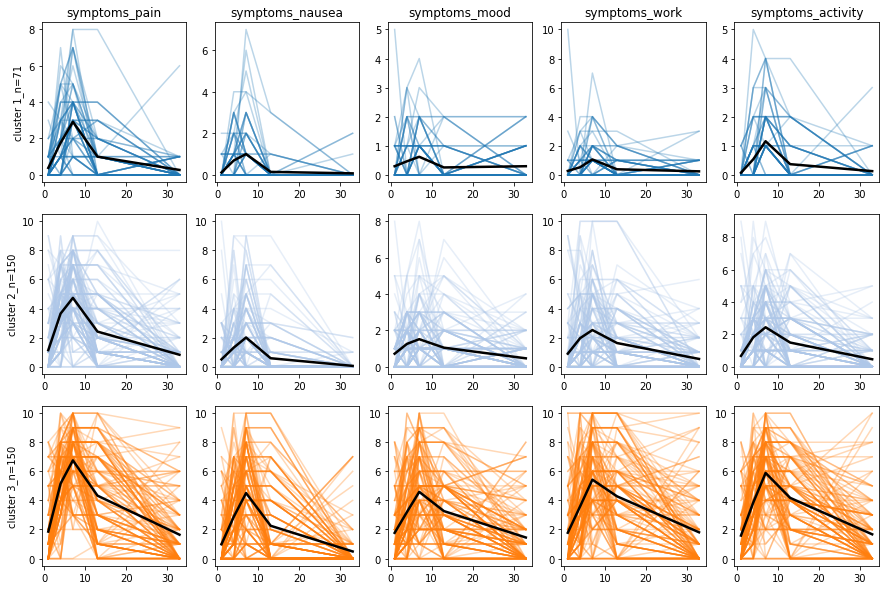

In [14]:
def plot_clusters(mdf):
    clusters = []
    symp_cols = ['symptoms_pain','symptoms_nausea','symptoms_mood','symptoms_work','symptoms_activity']#[c for c in mdf.columns if 'symptom' in c]
    
    dates = [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268]
    date_groups =  [[1,0,2],[4,3,2,5],[7,6,5,4],[13,7],[33,59,85,268]]
    date_approx = [i[0] for i in date_groups]
    mdf = mdf.copy()
    colors = plt.get_cmap('tab20')
    fig,ax = plt.subplots(len(np.unique(mdf.cluster)),len(symp_cols),figsize=[15,10])
    for clust, clust_df in mdf.groupby('cluster'):
        for col,s in enumerate(symp_cols):
            #list of lists, i think
            svals = clust_df[s].apply(lambda x: key_points(x,dates,date_groups)).values
            print(clust,clust_df.shape[0])
            this_ax = ax[clust-1,col]
            for sv in svals:
                this_ax.plot(date_approx,sv,color=colors(clust-1),alpha=.3,linewidth=1.5)
#                 this_ax.plot(date_approx,[svv-sv[0] for svv in sv],color=colors(clust-1),alpha=.3,linewidth=1.5)
            mval = np.stack(svals).mean(axis=0).ravel()
            this_ax.plot(date_approx,mval,color='black',linewidth=2.5)
#             this_ax.plot(date_approx,[mvv-mval[0] for mvv in mval],color='black',linewidth=2.5)
            if clust == 1:
                this_ax.set_title(s)
            if col == 0:
                this_ax.set_ylabel('cluster ' + str(clust) + '_n=' + str(clust_df.shape[0]))
# temp_mdf = add_clusters(ddict, clusterer=Cluster.SimilarityClusterer(4), sim_func = lambda x,y: 1/(1+dtw_ndim.distance(x,y,max_step=8)))
# temp_mdf = add_clusters(ddict, clusterer=Cluster.SimilarityClusterer(7,link='average'), sim_func = lambda x,y: 1/(1+dtw_ndim.distance(x,y)))
temp_mdf = add_clusters(ddict, clusterer=Cluster.SimilarityClusterer(3), sim_func = lambda x,y: 1/(1+dtw_ndim.distance(x,y)))
plot_clusters(temp_mdf)

In [ ]:
Utils.np_dict_to_json(sc,Const.symptom_similarity_results_json,True)

In [ ]:
#Belows is stuff I was doing for getting to the 

In [ ]:
#this should output an array with all the states of the symptoms (previous timepoint + current timepoint), for markov stuff idk
#or juust call the symptom_state_arrays for a simpler array of every state

def symptom_arrays(symp_dict):
    #{symptom: array<n_patients X n_symptoms x n_timepoints>}
    #order given in Const.symptoms
    symptom_arrays = []
    for s in Const.symptoms:
        arr = np.stack([v['symptoms'][s] for k,v in symp_dict['patients'].items()])
        symptom_arrays.append(arr)
    return np.stack(symptom_arrays,1)

def symptom_state_arrays(symp_dict,memory = 1,remove_allnan = True):
    #creates an array of the markov states for each syptom timepoint
    # (npeople * (ntimepoints - memory) x n_symptoms x (memory + 1) <- minus any nan states
    #memory is the # previous states included in the state
    #last axis the all saved timepoints, currently skips first steps until there is enough memory
    #remove_allnan will remove any states that are all nan (inlcuding memory)
    symp_array = symptom_arrays(symp_dict)
    (n_patients, n_symptoms, n_timepoints) = symp_array.shape
    #-1 means there is in issue
    states = []
    for t in range(memory,n_timepoints):
        curr_states = symp_array[:,:,t-memory:t+1]
        states.append(curr_states)
    states = np.vstack(states)
    if remove_allnan:
        nanstates = np.isnan(states).all(axis=1).all(axis=1)
        print('removing', nanstates.sum(), 'invalid states')
        states = states[~nanstates]
    return states

symptom_arrays(ddict)

In [ ]:
symptom_state_arrays(ddict,memory = 1)

In [ ]:
#All Carlas Old code compiled into functions

In [ ]:
def make_symptom_df(starting_index=13, num_attributes = 28):
    #no idea
    df =pd.read_csv(Const.mdasi_folder + 'MDASI_short.csv')

    for i, row in df.iterrows():
        crt_list = row[starting_index:starting_index + num_attributes]    
        s = 0
        for elem in crt_list:
            if pd.isna(elem):
                s += 1


        if s < 14:
            for j in range(len(crt_list)):
                if pd.isna(crt_list[j]):
                    df.iloc[i, starting_index + j] = 0


    for k in range(1,12):
        starting_index = 13+28*k+1


        for i, row in df.iterrows():

            crt_list = row[starting_index:starting_index + num_attributes]    
            s = 0
            for elem in crt_list:
                if pd.isna(elem):
                    s += 1
            if s < 14:
                for j in range(len(crt_list)):
                    if pd.isna(crt_list[j]):
                        prev = df.iloc[i, starting_index + j -28]
                        prev_col_n=df.columns[[1,starting_index + j -28]]
                        prev_ind = starting_index + j -28
                        while pd.isna(prev) == True and prev_ind > 13+28:
                            prev_ind = prev_ind - 28
                            prev = df.iloc[i, prev_ind]
    #                                 prev_col_n=df.columns[[1,prev_ind]]
    #                                 print(prev_ind, prev, prev_col_n)
                        if pd.isna(prev):
                            prev = 0
        #                     df.iloc[i, starting_index + j] = df.iloc[i, starting_index + j -28]
                        df.iloc[i, starting_index + j] = prev
    return df

df = make_symptom_df()
df.head()

In [ ]:
#check for patients with no symptom ratings

def check_no_symptoms(dframe):
    no_symptoms = []
    for i, row in dframe.iterrows():
        if pd.isna(row['baseline_mdasi_pain']) and \
        pd.isna(row['baseline_mdasi_fatigue']) and \
        pd.isna(row['baseline_mdasi_nausea']) and \
        pd.isna(row['baseline_mdasi_sleep']) and \
        pd.isna(row['startRT_mdasi_pain']) and \
        pd.isna(row['startRT_mdasi_fatigue']) and \
        pd.isna(row['startRT_mdasi_nausea']) and \
        pd.isna(row['startRT_mdasi_sleep']) and \
        pd.isna(row['wk_2_mdasi_pain']) and \
        pd.isna(row['wk_2_mdasi_fatigue']) and \
        pd.isna(row['wk_2_mdasi_nausea']) and \
        pd.isna(row['wk_2_mdasi_sleep']) and \
        pd.isna(row['wk_3_mdasi_pain']) and \
        pd.isna(row['wk_3_mdasi_fatigue']) and \
        pd.isna(row['wk_3_mdasi_nausea']) and \
        pd.isna(row['wk_3_mdasi_sleep']) and \
        pd.isna(row['wk_4_mdasi_pain']) and \
        pd.isna(row['wk_4_mdasi_fatigue']) and \
        pd.isna(row['wk_4_mdasi_nausea']) and \
        pd.isna(row['wk_4_mdasi_sleep']) and \
        pd.isna(row['wk_5_mdasi_pain']) and \
        pd.isna(row['wk_5_mdasi_fatigue']) and \
        pd.isna(row['wk_5_mdasi_nausea']) and \
        pd.isna(row['wk_5_mdasi_sleep']) and \
        pd.isna(row['wk_6_mdasi_pain']) and \
        pd.isna(row['wk_6_mdasi_fatigue']) and \
        pd.isna(row['wk_6_mdasi_nausea']) and \
        pd.isna(row['wk_6_mdasi_sleep']) and \
        pd.isna(row['endRT_mdasi_pain']) and \
        pd.isna(row['endRT_mdasi_fatigue']) and \
        pd.isna(row['endRT_mdasi_nausea']) and \
        pd.isna(row['endRT_mdasi_sleep']) and \
        pd.isna(row['wk6_post_mdasi_pain']) and \
        pd.isna(row['wk6_post_mdasi_fatigue']) and \
        pd.isna(row['wk6_post_mdasi_nausea']) and \
        pd.isna(row['wk6_post_mdasi_sleep']) and \
        pd.isna(row['M6_mdasi_pain']) and \
        pd.isna(row['M6_mdasi_fatigue']) and \
        pd.isna(row['M6_mdasi_nausea']) and \
        pd.isna(row['M6_mdasi_sleep']) and \
        pd.isna(row['M12_mdasi_pain']) and \
        pd.isna(row['M12_mdasi_fatigue']) and \
        pd.isna(row['M12_mdasi_nausea']) and \
        pd.isna(row['M12_mdasi_sleep']) and \
        pd.isna(row['M18_mdasi_pain']) and \
        pd.isna(row['M18_mdasi_fatigue']) and \
        pd.isna(row['M18_mdasi_nausea']) and \
        pd.isna(row['M18_mdasi_sleep']):
            no_symptoms.append(row.id)
    return no_symptoms

def replace_symptom_nan(dframe):
    #replace NaN values for ic and cc with 0 
    d = dframe.copy()
    for i, row in d.iterrows():
        if pd.isna(row['ic']): 
            d.at[i,'ic'] = 0
        if pd.isna(row['concurrent']): 
            d.at[i,'concurrent'] = 0
    return d

def replace_symptom_names(dframe):
    rename_dict = {'concurrent':'cc',
                   'baseline_mdasi_pain':"0_pain", 'baseline_mdasi_fatigue':"0_fatigue", 
                   'baseline_mdasi_nausea':"0_nausea",  'baseline_mdasi_sleep':"0_sleep", 
                   'baseline_mdasi_distress':"0_distress", 'baseline_mdasi_sob':"0_sob", 
                   'baseline_mdasi_memory':"0_memory", 'baseline_mdasi_appetite':"0_appetite", 
                   'baseline_mdasi_drowsy':"0_drowsy",  'baseline_mdasi_drymouth':"0_drymouth", 
                   'baseline_mdasi_sad':"0_sadness", 'baseline_mdasi_vomit':"0_vomit", 
                   'baseline_mdasi_numb':"0_numbness", 'baseline_mdasi_mucus':"0_mucus", 
                   'baseline_mdasi_swallow':"0_swallow",'baseline_mdasi_choke':"0_choking", 
                   'baseline_mdasi_voice':"0_voice",'baseline_mdasi_skin':"0_skin", 
                   'baseline_mdasi_constipation':"0_constipation", 'baseline_mdasi_taste':"0_taste",  
                   'baseline_mdasi_mucositis':"0_mucositis", 'baseline_mdasi_teeth':"0_teeth", 
                   'baseline_general_activity':"0_activity", 'baseline_mdasi_mood':"0_mood", 'baseline_mdasi_work':"0_work", 
                   'baseline_mdasi_relations':"0_relations",'baseline_mdasi_walking':"0_walking",
                   'baseline_mdasi_enjoy':"0_enjoyment",
                   'startRT_mdasi_pain':"1_pain", 'startRT_mdasi_fatigue':"1_fatigue", 'startRT_mdasi_nausea':"1_nausea",
                   'startRT_mdasi_sleep':"1_sleep", 'startRT_mdasi_distress':"1_distress",
                    'startRT_mdasi_sob':"1_sob", 'startRT_mdasi_memory':"1_memory",
                   'wk_2_mdasi_pain':"2_pain", 'wk_2_mdasi_fatigue':"2_fatigue", 
                   'wk_2_mdasi_nausea':"2_nausea",  'wk_2_mdasi_sleep':"2_sleep", 
                   'wk_2_mdasi_distress':"2_distress", 'wk_2_mdasi_sob':"2_sob", 'wk_2_mdasi_memory':"2_memory", 
                   'wk_2_mdasi_appetite':"2_appetite", 'wk_2_mdasi_drowsy':"2_drowsy",  'wk_2_mdasi_drymouth':"2_drymouth", 
                   'wk_2_mdasi_sad':"2_sadness", 'wk_2_mdasi_vomit':"2_vomit", 'wk_2_mdasi_numb':"2_numbness", 'wk_2_mdasi_mucus':"2_mucus", 
                   'wk_2_mdasi_swallow':"2_swallow",'wk_2_mdasi_choke':"2_choking", 'wk_2_mdasi_voice':"2_voice",'wk_2_mdasi_skin':"2_skin", 
                   'wk_2_mdasi_constipation':"2_constipation", 'wk_2_mdasi_taste':"2_taste",  'wk_2_mdasi_mucositis':"2_mucositis",
                   'wk_2_mdasi_teeth':"2_teeth", 'wk_2_general_activity':"2_activity", 'wk_2_mdasi_mood':"2_mood", 'wk_2_mdasi_work':"2_work", 
                   'startRT_mdasi_appetite':"1_appetite", 'startRT_mdasi_drowsy':"1_drowsy",  'startRT_mdasi_drymouth':"1_drymouth",
                   'wk_2_mdasi_relations':"2_relations",'wk_2_mdasi_walking':"2_walking",'wk_2_mdasi_enjoy':"2_enjoyment",
                   'startRT_mdasi_sad':"1_sadness", 'startRT_mdasi_vomit':"1_vomit", 'startRT_mdasi_numb':"1_numbness", 'startRT_mdasi_mucus':"1_mucus",
                   'startRT_mdasi_swallow':"1_swallow",'startRT_mdasi_choke':"1_choking", 'startRT_mdasi_voice':"1_voice",'startRT_mdasi_skin':"1_skin",
                   'startRT_mdasi_constipation':"1_constipation", 'startRT_mdasi_taste':"1_taste",  'startRT_mdasi_mucositis':"1_mucositis",
                   'startRT_mdasi_teeth':"1_teeth", 'startRT_general_activity':"1_activity", 'startRT_mdasi_mood':"1_mood",
                   'startRT_mdasi_work':"1_work", 'startRT_mdasi_relations':"1_relations",'startRT_mdasi_walking':"1_walking",
                   'startRT_mdasi_enjoy':"1_enjoyment",
                  }
    #rename concurrent column with cc
    d = dframe.rename(columns = {'concurrent':"cc"}, inplace=False)
    d = d.rename(columns = {,  ,, , , , , , ,',}, inplace=False)
    d = d.rename(columns = {,}, inplace=False)
    d = d.rename(columns = {'wk_3_mdasi_pain':"3_pain", 'wk_3_mdasi_fatigue':"3_fatigue", 'wk_3_mdasi_nausea':"3_nausea",  'wk_3_mdasi_sleep':"3_sleep", 'wk_3_mdasi_distress':"3_distress", 'wk_3_mdasi_sob':"3_sob", 'wk_3_mdasi_memory':"3_memory", 'wk_3_mdasi_appetite':"3_appetite", 'wk_3_mdasi_drowsy':"3_drowsy",  'wk_3_mdasi_drymouth':"3_drymouth", 'wk_3_mdasi_sad':"3_sadness", 'wk_3_mdasi_vomit':"3_vomit", 'wk_3_mdasi_numb':"3_numbness", 'wk_3_mdasi_mucus':"3_mucus", 'wk_3_mdasi_swallow':"3_swallow",'wk_3_mdasi_choke':"3_choking", 'wk_3_mdasi_voice':"3_voice",'wk_3_mdasi_skin':"3_skin", 'wk_3_mdasi_constipation':"3_constipation", 'wk_3_mdasi_taste':"3_taste",  'wk_3_mdasi_mucositis':"3_mucositis", 'wk_3_mdasi_teeth':"3_teeth", 'wk_3_general_activity':"3_activity", 'wk_3_mdasi_mood':"3_mood", 'wk_3_mdasi_work':"3_work", 'wk_3_mdasi_relations':"3_relations",'wk_3_mdasi_walking':"3_walking",'wk_3_mdasi_enjoy':"3_enjoyment",}, inplace=False)
    d = d.rename(columns = {'wk_4_mdasi_pain':"4_pain", 'wk_4_mdasi_fatigue':"4_fatigue", 'wk_4_mdasi_nausea':"4_nausea",  'wk_4_mdasi_sleep':"4_sleep", 'wk_4_mdasi_distress':"4_distress", 'wk_4_mdasi_sob':"4_sob", 'wk_4_mdasi_memory':"4_memory", 'wk_4_mdasi_appetite':"4_appetite", 'wk_4_mdasi_drowsy':"4_drowsy",  'wk_4_mdasi_drymouth':"4_drymouth", 'wk_4_mdasi_sad':"4_sadness", 'wk_4_mdasi_vomit':"4_vomit", 'wk_4_mdasi_numb':"4_numbness", 'wk_4_mdasi_mucus':"4_mucus", 'wk_4_mdasi_swallow':"4_swallow",'wk_4_mdasi_choke':"4_choking", 'wk_4_mdasi_voice':"4_voice",'wk_4_mdasi_skin':"4_skin", 'wk_4_mdasi_constipation':"4_constipation", 'wk_4_mdasi_taste':"4_taste",  'wk_4_mdasi_mucositis':"4_mucositis", 'wk_4_mdasi_teeth':"4_teeth", 'wk_4_general_activity':"4_activity", 'wk_4_mdasi_mood':"4_mood", 'wk_4_mdasi_work':"4_work", 'wk_4_mdasi_relations':"4_relations",'wk_4_mdasi_walking':"4_walking",'wk_4_mdasi_enjoy':"4_enjoyment",}, inplace=False)
    d = d.rename(columns = {'wk_5_mdasi_pain':"5_pain", 'wk_5_mdasi_fatigue':"5_fatigue", 'wk_5_mdasi_nausea':"5_nausea",  'wk_5_mdasi_sleep':"5_sleep", 'wk_5_mdasi_distress':"5_distress", 'wk_5_mdasi_sob':"5_sob", 'wk_5_mdasi_memory':"5_memory", 'wk_5_mdasi_appetite':"5_appetite", 'wk_5_mdasi_drowsy':"5_drowsy",  'wk_5_mdasi_drymouth':"5_drymouth", 'wk_5_mdasi_sad':"5_sadness", 'wk_5_mdasi_vomit':"5_vomit", 'wk_5_mdasi_numb':"5_numbness", 'wk_5_mdasi_mucus':"5_mucus", 'wk_5_mdasi_swallow':"5_swallow",'wk_5_mdasi_choke':"5_choking", 'wk_5_mdasi_voice':"5_voice",'wk_5_mdasi_skin':"5_skin", 'wk_5_mdasi_constipation':"5_constipation", 'wk_5_mdasi_taste':"5_taste",  'wk_5_mdasi_mucositis':"5_mucositis", 'wk_5_mdasi_teeth':"5_teeth", 'wk_5_general_activity':"5_activity", 'wk_5_mdasi_mood':"5_mood", 'wk_5_mdasi_work':"5_work", 'wk_5_mdasi_relations':"5_relations",'wk_5_mdasi_walking':"5_walking",'wk_5_mdasi_enjoy':"5_enjoyment",}, inplace=False)
    d = d.rename(columns = {'wk_6_mdasi_pain':"6_pain", 'wk_6_mdasi_fatigue':"6_fatigue", 'wk_6_mdasi_nausea':"6_nausea",  'wk_6_mdasi_sleep':"6_sleep", 'wk_6_mdasi_distress':"6_distress", 'wk_6_mdasi_sob':"6_sob", 'wk_6_mdasi_memory':"6_memory", 'wk_6_mdasi_appetite':"6_appetite", 'wk_6_mdasi_drowsy':"6_drowsy",  'wk_6_mdasi_drymouth':"6_drymouth", 'wk_6_mdasi_sad':"6_sadness", 'wk_6_mdasi_vomit':"6_vomit", 'wk_6_mdasi_numb':"6_numbness", 'wk_6_mdasi_mucus':"6_mucus", 'wk_6_mdasi_swallow':"6_swallow",'wk_6_mdasi_choke':"6_choking", 'wk_6_mdasi_voice':"6_voice",'wk_6_mdasi_skin':"6_skin", 'wk_6_mdasi_constipation':"6_constipation", 'wk_6_mdasi_taste':"6_taste",  'wk_6_mdasi_mucositis':"6_mucositis", 'wk_6_mdasi_teeth':"6_teeth", 'wk_6_general_activity':"6_activity", 'wk_6_mdasi_mood':"6_mood", 'wk_6_mdasi_work':"6_work", 'wk_6_mdasi_relations':"6_relations",'wk_6_mdasi_walking':"6_walking",'wk_6_mdasi_enjoy':"6_enjoyment",}, inplace=False)
    d = d.rename(columns = {'endRT_mdasi_pain':"7_pain", 'endRT_mdasi_fatigue':"7_fatigue", 'endRT_mdasi_nausea':"7_nausea",  'endRT_mdasi_sleep':"7_sleep", 'endRT_mdasi_distress':"7_distress", 'endRT_mdasi_sob':"7_sob", 'endRT_mdasi_memory':"7_memory", 'endRT_mdasi_appetite':"7_appetite", 'endRT_mdasi_drowsy':"7_drowsy",  'endRT_mdasi_drymouth':"7_drymouth", 'endRT_mdasi_sad':"7_sadness", 'endRT_mdasi_vomit':"7_vomit", 'endRT_mdasi_numb':"7_numbness", 'endRT_mdasi_mucus':"7_mucus", 'endRT_mdasi_swallow':"7_swallow",'endRT_mdasi_choke':"7_choking", 'endRT_mdasi_voice':"7_voice",'endRT_mdasi_skin':"7_skin", 'endRT_mdasi_constipation':"7_constipation", 'endRT_mdasi_taste':"7_taste",  'endRT_mdasi_mucositis':"7_mucositis", 'endRT_mdasi_teeth':"7_teeth", 'endRT_general_activity':"7_activity", 'endRT_mdasi_mood':"7_mood", 'endRT_mdasi_work':"7_work", 'endRT_mdasi_relations':"7_relations",'endRT_mdasi_walking':"7_walking",'endRT_mdasi_enjoy':"7_enjoyment",}, inplace=False)
    d = d.rename(columns = {'wk6_post_mdasi_pain':"13_pain", 'wk6_post_mdasi_fatigue':"13_fatigue", 'wk6_post_mdasi_nausea':"13_nausea",  'wk6_post_mdasi_sleep':"13_sleep", 'wk6_post_mdasi_distress':"13_distress", 'wk6_post_mdasi_sob':"13_sob", 'wk6_post_mdasi_memory':"13_memory", 'wk6_post_mdasi_appetite':"13_appetite", 'wk6_post_mdasi_drowsy':"13_drowsy",  'wk6_post_mdasi_drymouth':"13_drymouth", 'wk6_post_mdasi_sad':"13_sadness", 'wk6_post_mdasi_vomit':"13_vomit", 'wk6_post_mdasi_numb':"13_numbness", 'wk6_post_mdasi_mucus':"13_mucus", 'wk6_post_mdasi_swallow':"13_swallow",'wk6_post_mdasi_choke':"13_choking", 'wk6_post_mdasi_voice':"13_voice",'wk6_post_mdasi_skin':"13_skin", 'wk6_post_mdasi_constipation':"13_constipation", 'wk6_post_mdasi_taste':"13_taste",  'wk6_post_mdasi_mucositis':"13_mucositis", 'wk6_post_mdasi_teeth':"13_teeth", 'wk6_post_general_activity':"13_activity", 'wk6_post_mdasi_mood':"13_mood", 'wk6_post_mdasi_work':"13_work", 'wk6_post_mdasi_relations':"13_relations",'wk6_post_mdasi_walking':"13_walking",'wk6_post_mdasi_enjoy':"13_enjoyment",}, inplace=False)
    d = d.rename(columns = {'M6_mdasi_pain':"p6_pain", 'M6_mdasi_fatigue':"p6_fatigue", 'M6_mdasi_nausea':"p6_nausea",  'M6_mdasi_sleep':"p6_sleep", 'M6_mdasi_distress':"p6_distress", 'M6_mdasi_sob':"p6_sob", 'M6_mdasi_memory':"p6_memory", 'M6_mdasi_appetite':"p6_appetite", 'M6_mdasi_drowsy':"p6_drowsy",  'M6_mdasi_drymouth':"p6_drymouth", 'M6_mdasi_sad':"p6_sadness", 'M6_mdasi_vomit':"p6_vomit", 'M6_mdasi_numb':"p6_numbness", 'M6_mdasi_mucus':"p6_mucus", 'M6_mdasi_swallow':"p6_swallow",'M6_mdasi_choke':"p6_choking", 'M6_mdasi_voice':"p6_voice",'M6_mdasi_skin':"p6_skin", 'M6_mdasi_constipation':"p6_constipation", 'M6_mdasi_taste':"p6_taste",  'M6_mdasi_mucositis':"p6_mucositis", 'M6_mdasi_teeth':"p6_teeth", 'M6_general_activity':"p6_activity", 'M6_mdasi_mood':"p6_mood", 'M6_mdasi_work':"p6_work", 'M6_mdasi_relations':"p6_relations",'M6_mdasi_walking':"p6_walking",'M6_mdasi_enjoy':"p6_enjoyment",}, inplace=False)
    d = d.rename(columns = {'M12_mdasi_pain':"p12_pain", 'M12_mdasi_fatigue':"p12_fatigue", 'M12_mdasi_nausea':"p12_nausea",  'M12_mdasi_sleep':"p12_sleep", 'M12_mdasi_distress':"p12_distress", 'M12_mdasi_sob':"p12_sob", 'M12_mdasi_memory':"p12_memory", 'M12_mdasi_appetite':"p12_appetite", 'M12_mdasi_drowsy':"p12_drowsy",  'M12_mdasi_drymouth':"p12_drymouth", 'M12_mdasi_sad':"p12_sadness", 'M12_mdasi_vomit':"p12_vomit", 'M12_mdasi_numb':"p12_numbness", 'M12_mdasi_mucus':"p12_mucus", 'M12_mdasi_swallow':"p12_swallow",'M12_mdasi_choke':"p12_choking", 'M12_mdasi_voice':"p12_voice",'M12_mdasi_skin':"p12_skin", 'M12_mdasi_constipation':"p12_constipation", 'M12_mdasi_taste':"p12_taste",  'M12_mdasi_mucositis':"p12_mucositis", 'M12_mdasi_teeth':"p12_teeth", 'M12_general_activity':"p12_activity", 'M12_mdasi_mood':"p12_mood", 'M12_mdasi_work':"p12_work", 'M12_mdasi_relations':"p12_relations",'M12_mdasi_walking':"p12_walking",'M12_mdasi_enjoy':"p12_enjoyment",}, inplace=False)
    d = d.rename(columns = {'M18_mdasi_pain':"p18_pain", 'M18_mdasi_fatigue':"p18_fatigue", 'M18_mdasi_nausea':"p18_nausea",  'M18_mdasi_sleep':"p18_sleep", 'M18_mdasi_distress':"p18_distress", 'M18_mdasi_sob':"p18_sob", 'M18_mdasi_memory':"p18_memory", 'M18_mdasi_appetite':"p18_appetite", 'M18_mdasi_drowsy':"p18_drowsy",  'M18_mdasi_drymouth':"p18_drymouth", 'M18_mdasi_sad':"p18_sadness", 'M18_mdasi_vomit':"p18_vomit", 'M18_mdasi_numb':"p18_numbness", 'M18_mdasi_mucus':"p18_mucus", 'M18_mdasi_swallow':"p18_swallow",'M18_mdasi_choke':"p18_choking", 'M18_mdasi_voice':"p18_voice",'M18_mdasi_skin':"p18_skin", 'M18_mdasi_constipation':"p18_constipation", 'M18_mdasi_taste':"p18_taste",  'M18_mdasi_mucositis':"p18_mucositis", 'M18_mdasi_teeth':"p18_teeth", 'M18_general_activity':"p18_activity", 'M18_mdasi_mood':"p18_mood", 'M18_mdasi_work':"p18_work", 'M18_mdasi_relations':"p18_relations",'M18_mdasi_walking':"p18_walking",'M18_mdasi_enjoy':"p18_enjoyment",}, inplace=False)
    return d

def clean_symptom_df(dframe):
    no_symptoms = set(check_no_symptoms(dframe))
    d = dframe[~dframe.id.isin(no_symptoms)]
    d = replace_symptom_nan(d)
    
    #rename concurrent column with cc
    d = replace_symptom_names(d)
    
    #this part is missing <check_one_timepoint>
    #replace baseline missing values with 0 for patients who have at least 1 rating dif than 0 during baseline
#     for i, row in d.iterrows():
#         rez = check_one_timepoint(row[13:41])
#         if rez == True:
#             d.iloc[i-1,13:41] = d.iloc[i-1,13:41].fillna(0)
    return d

df = clean_symptom_df(df)
df

In [ ]:
def symptom_df_to_dict(dframe):
    
    patients = {}
    for i, row in dframe.iterrows():
        for el in row:

            patients[row["id"]] = {}

            patients[row['id']]["demographics"] = {"gender":row["sex"], "age":row["age"]}

            treatment = ""
            if not np.isnan(row['ic']) and pd.to_numeric(row['ic']) == 1:
                treatment += "ic"
            if not np.isnan(row['cc']) and pd.to_numeric(row['cc']) == 1:
                treatment +="cc"
            patients[row['id']]['clinical'] ={"site_of_tumor":row["site_of_tumor"], "t":row['t_numeric'], "n":row["n_nominal"], 'treatment':treatment } 

            patients[row['id']]['symptoms'] = {}
            first_symp_index = 13
            for s_index, s in enumerate(symptoms):
                patients[row['id']]['symptoms'][s] =[]
                for timepoint in range(12):
                    patients[row['id']]['symptoms'][s].append(row[first_symp_index + 28* timepoint + s_index])
    return patients

sdict = symptom_df_to_dict(df)
sdict

In [ ]:
with open(Const.mdasi_folder + "patients.json", "wb") as f:
    f.write(json.dumps(sdict, indent = 4).encode("utf-8"))